# Hyperparameter tuning (Spark based recommender)

Hyperparameter tuning for Spark based recommender algorithm is important to select a model with the optimal performance. This notebook introduces good practices in performing hyperparameter tuning for building recommender models with the utility functions provided in the Microsoft/Recommenders repository.

## 0 Global settings and import

In [1]:
# set the environment path to find Recommenders
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import sys
sys.path.append("../../")
import pandas as pd
import numpy as np
import time

import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample

from reco_utils.common.spark_utils import start_or_get_spark
from reco_utils.evaluation.spark_evaluation import SparkRankingEvaluation, SparkRatingEvaluation
from reco_utils.dataset.movielens import load_spark_df
from reco_utils.dataset.spark_splitters import spark_random_split

from numba import autojit

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("PySpark version: {}".format(pyspark.__version__))

System version: 3.6.0 | packaged by conda-forge | (default, Feb  9 2017, 14:36:55) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
Pandas version: 0.23.4
PySpark version: 2.3.1


In [2]:
%env PYSPARK_PYTHON=/anaconda/envs/recommender/bin/python
%env PYSPARK_DRIVER_PYTHON=/anaconda/envs/recommender/bin/python

env: PYSPARK_PYTHON=/anaconda/envs/recommender/bin/python
env: PYSPARK_DRIVER_PYTHON=/anaconda/envs/recommender/bin/python


In [3]:
COL_USER = "UserId"
COL_ITEM = "MovieId"
COL_TIMESTAMP = "Timestamp"
COL_RATING = "Rating"
COL_PREDICTION = "prediction"

HEADER = {
    "col_user": COL_USER,
    "col_item": COL_ITEM,
    "col_rating": COL_RATING,
    "col_prediction": COL_PREDICTION,
}

HEADER_ALS = {
    "userCol": COL_USER,
    "itemCol": COL_ITEM,
    "ratingCol": COL_RATING
}

## 1 Data preparation

For illustration purpose, data used for demonstrating the hyperparameter tuning practices is the Movielens 100k dataset. 

In [4]:
spark = start_or_get_spark()

Movielens 100k dataset is used for running the demonstration.

In [5]:
data = load_spark_df(spark, size='100k')

The dataset is split into 3 subsets randomly with a given split ratio. The hyperparameter tuning is performed on the training and the validating data, and then the optimal recommender selected is evaluated on the testing dataset.

In [6]:
train, valid, test = spark_random_split(data, ratio=[4, 4, 2])

## 2 Hyper parameter tuning with Azure Machine Learning Services

The `hyperdrive` module in the [Azure Machine Learning Services](https://azure.microsoft.com/en-us/services/machine-learning-service/) is supposed to run [hyperparameter tuning and optimizing for machine learning model selection](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-tune-hyperparameters). At the moment, the service supports running hyperparameter tuning on heterogenous computing targets such as cluster of commodity compute nodes with or without GPU devices (see detailed documentation [here](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-set-up-training-targets)). It is feasible to run parameter tuning on a cluster of VM nodes. In this case, the service containerizes individual and independent Spark session on each node of the cluster to run the parameter tuning job in parallel, instead of inside a single Spark session where the training is executed in a distributed manner.  

It is worth mentioning that tuning hyperparameter with `hyperdrive` in Azure Machine Learning services will be a feature in the future version. 

Detailed instructions of tuning hyperparameter of non-Spark workloads by using Azure Machine Learning Services can be found in [this](https://github.com/Microsoft/Recommenders.git) notebook. 

## 3 Hyper parameter tuning with Spark ML constructs

Spark ML lib implements modules such as `CrossValidator` and `TrainValidationSplit` for tuning hyperparameters (see [here](https://spark.apache.org/docs/2.2.0/ml-tuning.html)). However, by default, it does not support custom machine learning algorithms, data splitting methods, and evaluation metrics, which are commonly used in recommendation scenario. 

For example, the Spark native constuct can be used for tuning a recommender against the `rmse` metric which is one of the available regression metrics in Spark.

Firstly, a Spark ALS object needs to be created.

In [7]:
# NOTE the parameters of interest, rank and regParam, are left unset, 
# because their values will be assigned in the parameter grid builder.
als = ALS(
    maxIter=15,
    implicitPrefs=False,
    alpha=0.1,
    coldStartStrategy='drop',
    nonnegative=False,
    **HEADER_ALS
)

Then, a parameter grid can be defined as follows. For illustration purpose, only `rank` and `regParam` are considered.

In [8]:
paramGrid = ParamGridBuilder() \
    .addGrid(als.rank, [10, 20]) \
    .addGrid(als.regParam, [1, 0.1, 0.01, 0.001, 0.0001]) \
    .build()

Given the settings above, a `TrainValidationSplit` constructor can be created for fitting the best model in the given parameter range.

In [9]:
tvs = TrainValidationSplit(
    estimator=als,
    estimatorParamMaps=paramGrid,
    # A regression evaluation method is used. 
    evaluator=RegressionEvaluator(labelCol='Rating'),
    # 80% of the data will be used for training, 20% for validation.
    # NOTE here the splitting is random. The Spark splitting utilities (e.g. chrono splitter)
    # are therefore not available here. 
    trainRatio=0.8
)

In [10]:
time_start = time.time()

# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(train)

time_spark = time.time() - time_start

The model parameters in the grid and the best metrics can be then returned. 

In [11]:
model.explainParams()

"estimator: estimator to be cross-validated (current: ALS_4fa58c7f07a708200b53)\nestimatorParamMaps: estimator param maps (current: [{Param(parent='ALS_4fa58c7f07a708200b53', name='rank', doc='rank of the factorization'): 10, Param(parent='ALS_4fa58c7f07a708200b53', name='regParam', doc='regularization parameter (>= 0).'): 1}, {Param(parent='ALS_4fa58c7f07a708200b53', name='rank', doc='rank of the factorization'): 10, Param(parent='ALS_4fa58c7f07a708200b53', name='regParam', doc='regularization parameter (>= 0).'): 0.1}, {Param(parent='ALS_4fa58c7f07a708200b53', name='rank', doc='rank of the factorization'): 10, Param(parent='ALS_4fa58c7f07a708200b53', name='regParam', doc='regularization parameter (>= 0).'): 0.01}, {Param(parent='ALS_4fa58c7f07a708200b53', name='rank', doc='rank of the factorization'): 10, Param(parent='ALS_4fa58c7f07a708200b53', name='regParam', doc='regularization parameter (>= 0).'): 0.001}, {Param(parent='ALS_4fa58c7f07a708200b53', name='rank', doc='rank of the fa

In [12]:
model.validationMetrics

[1.3818693574087881,
 1.03881169247089,
 1.4149480500849774,
 1.8957753237837804,
 2.707401263212467,
 1.3818693597518183,
 1.022026009040587,
 1.4517896758192947,
 1.9079444576340328,
 2.786421555547063]

Get the best model.

In [13]:
model_best_spark = model.bestModel

## 3 Hyper parameter tuning with `hyperopt` in sequential mode

`hyperopt` is an open source Python package that is designed for tuning parameters for generic function with pre-defined loss. More information about `hyperopt` can be found [here](https://github.com/hyperopt/hyperopt).

An *objective* function is defined for optimizing the hyper parameters. In this case, the objective is to **maximize** the metric of **precision@k** for a recommender. To illustrate, the recommender is built with Spark ALS implementation (**NOTE** though the Spark ALS algorithm is demonstrated, the walk-through in the notebook is not meant for distributed / parallel execution of the hyper parameter searching). The arguments of the objective function are parameters used for building and evaluating the ALS-based recommender. Parameters of **rank** and **reg**, which controls number of latent factors and regularization, respectively, are considered as hyper parameters. Note the loss can be defined as demand, depending on the actual recommendation use case scenario. For example, in the case of predicting ratings, a regression loss by using metrics like RMSE, MAE, etc., can be useful, while in the case of recommending a list of items, a ranking loss like precision, recall, etc., are preferred. 

The objective function shown below demonstrates a precision@k loss for ALS recommender. It is worth noting that `hyperopt` only supports minimization so in our case, `-precision` is used in the loss because the larger precision@k the better.

In [14]:
# Customize an objective function
def objective(params):
    rank = params['rank']
    reg = params['reg']
    train = params['train'] 
    valid = params['valid'] 
    col_user = params['col_user'] 
    col_item = params['col_item']
    col_rating = params['col_rating'] 
    col_prediction = params['col_prediction'] 
    k = params['k']
    relevancy_method = params['relevancy_method']
    
    als = ALS(
        rank=rank,
        maxIter=15,
        implicitPrefs=False,
        alpha=0.1,
        regParam=reg,
        coldStartStrategy='drop',
        nonnegative=False,
        seed=0,
        **HEADER_ALS
    )
    
    model = als.fit(train)
    
    prediction = model.transform(valid)

    rating_eval = SparkRatingEvaluation(
        valid, 
        prediction, 
        **HEADER
    )
    
    rmse = rating_eval.rmse()
    
    # Return the objective function result.
    return {
       'loss': rmse,
       'status': STATUS_OK,
       'eval_time': time.time()
    }

`hyperopt` allows users to define a search space for hyper parameter exploration. Selection of search space is empirical, and it depends on the understanding of how distribution of parameter of interest affects the model performance measured by the loss function. 

In the ALS algorithm, the two hyper parameters, rank and reg, affect model performance in a way that
* The higher the rank, the better the model performance but also the higher risk of overfitting.
* The reg parameter is subject to rank and it prevents overfitting in certain way. 

Therefore, in this case, a uniform distribution and a lognormal distribution sampling spaces are used for rank and reg, respectively. A narrow search space is used for illustration purpose, that is, the range of rank is from 10 to 20, while that of reg is from $e^{-5}$ to $e^{-1}$. Together with the randomly sampled hyper parameters, other parameters use for building / evaluating the recommender, like `k`, column names, data, etc., are kept as constants.

In [15]:
# define a search space
space = {
    'rank': hp.quniform('rank', 10, 20, 5),
    'reg': hp.loguniform('reg', -5, -1),
    'train': train, 
    'valid': valid, 
    'col_user': "UserId", 
    'col_item': "MovieId", 
    'col_rating': "Rating", 
    'col_prediction': "prediction", 
    'k': 10,
    'relevancy_method': "top_k"
}

`fmin` of `hyperopt` is used for running the trials for searching optimal hyper parameters. In `hyperopt`, there are different strategies for intelligently optimize hyper parameters. For example, `hyperopt` avails Tree of Parzen Estimators (TPE) method for searching optimal parameters, which is more efficient than random search or grid search (details can be found [here](http://hyperopt.github.io/hyperopt/)). It is claimed in the project website that Bayesian based optimization method is planned but so far it has not yet been implemented. 

The following runs the trials with the pre-defined objective function and search space. TPE is used as the optimization method. Totally there will be 100 evaluations run for searching the best parameters.

**NOTE** having a sufficiently large number of evaluation iterations will give statistically sound measure of model performance across the parameter space, but it also deteriorates the efficiency of running the optimization. To improve this, one can distribute the parameter optimization process across a distributed nodes (see next Section 5 for more details). 

In [16]:
time_start = time.time()

# Trials for recording each iteration of the hyperparameter searching.
trials = Trials()

best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    trials=trials,
    max_evals=10
)
                  
time_hyperopt = time.time() - time_start

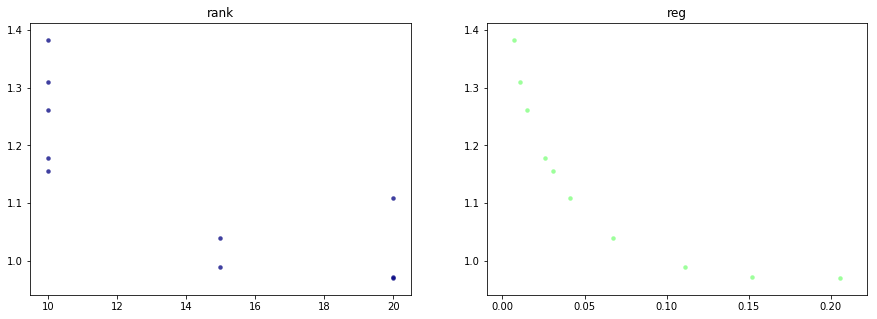

In [17]:
parameters = ['rank', 'reg']
cols = len(parameters)
f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(15,5))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75, c=cmap(float(i)/len(parameters)))
    axes[i].set_title(val)

It can be seen from the above plot that
* The actual impact of rank is in line with the intuition - the larger the value the better the result.
* It is interesting to see that the optimal value of reg is ~0.1. 

Get the best model.

In [18]:
als = ALS(
    rank=best["rank"],
    regParam=best["reg"],
    maxIter=15,
    implicitPrefs=False,
    alpha=0.1,
    coldStartStrategy='drop',
    nonnegative=False,
    seed=0,
    **HEADER_ALS
)
    
model_best_hyperopt = als.fit(train)

Note one can also use `hyperopt` for tuning prameters against other metrics. This can be simply done by modifying the `objective` function. The following shows an objective function of how to tune "precision@k". Since `fmin` in `hyperopt` only supports minimization while the actual objective of the loss is to maximize "precision@k", `-precision` instead of `precision` is used in the returned value of the `objective` function.

In [19]:
# Customize an objective function
def objective(params):
    rank = params['rank']
    reg = params['reg']
    train = params['train'] 
    valid = params['valid'] 
    col_user = params['col_user'] 
    col_item = params['col_item']
    col_rating = params['col_rating'] 
    col_prediction = params['col_prediction'] 
    k = params['k']
    relevancy_method = params['relevancy_method']
    
    header = {
        "userCol": col_user,
        "itemCol": col_item,
        "ratingCol": col_rating,
    }
    
    als = ALS(
        rank=rank,
        maxIter=15,
        implicitPrefs=False,
        alpha=0.1,
        regParam=reg,
        coldStartStrategy='drop',
        nonnegative=False,
        seed=0,
        **header
    )
    
    model = als.fit(train)
    
    users = train.select(col_user).distinct()
    items = train.select(col_item).distinct()
    user_item = users.crossJoin(items)
    dfs_pred = model.transform(user_item)

    # Remove seen items.
    dfs_pred_exclude_train = dfs_pred.alias("pred").join(
        train.alias("train"),
        (dfs_pred[col_user] == train[col_user]) & (dfs_pred[col_item] == train[col_item]),
        how='outer'
    )

    top_all = dfs_pred_exclude_train.filter(dfs_pred_exclude_train["train.Rating"].isNull()) \
        .select('pred.' + col_user, 'pred.' + col_item, 'pred.' + "prediction")
    
    top_all.cache().count()

    rank_eval = SparkRankingEvaluation(
        valid, 
        top_all, 
        k=k, 
        col_user=col_user, 
        col_item=col_item, 
        col_rating="Rating", 
        col_prediction="prediction", 
        relevancy_method=relevancy_method
    )
    
    precision = rank_eval.precision_at_k()
    
    # Return the objective function result.
    return {
        'loss': -precision,
        'status': STATUS_OK,
        'eval_time': time.time()
    }

## Hyperparameter tuning with `hyperopt` in parallel mode

Though `hyperopt` works well in a single node machine, its features (e.g., `Trials` module) do not support Spark environment. A good practice is to use `hyperopt` for sampling parameter values from the defined sampling space, and then parallelize the model training onto Spark cluster with the sampled parameter combinations.

The downside of this method is that the intelligent searching algorithm (i.e., TPE) of `hyperopt` cannot be used. The approach introduced here is therefore equivalent to random search.

Sample the parameters used for model building from the pre-defined space. Here, for illustration purpose, only 10 samples are generated.

In [20]:
import hyperopt.pyll.stochastic

time_start = time.time()

sample_params = [hyperopt.pyll.stochastic.sample(space) for x in range(10)]

If the master node of the Spark cluster has multiple cores, a local parallelization with Python `map` function can be used for running model building in parallel. Note here the Spark `flatMap` function cannot be used, but a nested parallelization is not allowed. 

The following runs model building on the sampled parameter values with the pre-defined objective function.

In [21]:
results_map = list(map(lambda x: objective(x), sample_params))

time_sample = time.time() - time_start

In [22]:
results_map

[{'loss': -0.061717921527041364,
  'status': 'ok',
  'eval_time': 1546842253.6588056},
 {'loss': -0.07179215270413572,
  'status': 'ok',
  'eval_time': 1546842275.0179348},
 {'loss': -0.0010604453870625664,
  'status': 'ok',
  'eval_time': 1546842295.555312},
 {'loss': -0.0984093319194062,
  'status': 'ok',
  'eval_time': 1546842317.4990594},
 {'loss': -0.09257688229056205, 'status': 'ok', 'eval_time': 1546842338.18564},
 {'loss': -0.08462354188759279,
  'status': 'ok',
  'eval_time': 1546842358.8877892},
 {'loss': -0.0704135737009544,
  'status': 'ok',
  'eval_time': 1546842379.2135687},
 {'loss': -0.10031813361611878,
  'status': 'ok',
  'eval_time': 1546842400.0779529},
 {'loss': -0.03934252386002121,
  'status': 'ok',
  'eval_time': 1546842420.502004},
 {'loss': -0.07444326617179221,
  'status': 'ok',
  'eval_time': 1546842440.7260087}]

Get the best model.

In [23]:
loss_metrics = np.array([x['loss'] for x in results_map])
best_loss = np.where(loss_metrics == min(loss_metrics))

In [24]:
best_param = sample_params[best_loss[0].item()]

In [25]:
als = ALS(
    rank=best_param["rank"],
    regParam=best_param["reg"],
    maxIter=15,
    implicitPrefs=False,
    alpha=0.1,
    coldStartStrategy='drop',
    nonnegative=False,
    seed=0,
    **HEADER_ALS
)
    
model_best_sample = als.fit(train)

`hyperopt` reduces the searching time dramatically.

## 4 Evaluation on testing data

The optimal parameters can then be used for building a recommender, which is then evaluated on the testing data.

In [26]:
# Get prediction results with the optimal modesl from different approaches.
prediction_spark = model_best_spark.transform(test)
prediction_hyperopt = model_best_hyperopt.transform(test)
prediction_sample = model_best_sample.transform(test)

predictions = [prediction_spark, prediction_hyperopt, prediction_sample]
elapsed = [time_spark, time_hyperopt, time_sample]

approaches = ['spark', 'hyperopt', 'sample']
comparison = pd.DataFrame()
for ind, approach in enumerate(approaches):    
    rating_eval = SparkRatingEvaluation(
        test, 
        predictions[ind],
        **HEADER
    )
    
    result = pd.DataFrame({
        'Approach': approach,
        'RMSE': rating_eval.rmse(),
        'MAE': rating_eval.mae(),
        'Explained variance': rating_eval.exp_var(),
        'R squared': rating_eval.rsquared(),
        'Elapsed': elapsed[ind]
    }, index=[0])
    
    comparison = comparison.append(result)

In [27]:
comparison

,Approach,RMSE,MAE,Explained variance,R squared,Elapsed
0,spark,0.991890,0.785606,0.248199,0.211332,58.837373
0,hyperopt,0.969520,0.779720,0.300912,0.246503,118.485334
0,sample,0.979039,0.777457,0.270985,0.231635,210.207612


In [94]:
comparison

,Approach,RMSE,MAE,Explained variance,R squared,Elapsed
0,spark,0.993568,0.787028,0.244673,0.208661,44.237093
0,hyperopt,0.968426,0.774891,0.295251,0.248203,116.420096
0,sample,0.985228,0.780406,0.258821,0.221890,211.739382


From the results, it can be seen that, *with the same number of iterations*, Spark native construct based approach takes the least amount of time, and not suprisingly, sample based approach takes the most amount of time. The three approaches use the same objective which is RMSE. In this measure, the `hyperopt` based approach performs the best. This may be owing to the TPE searching algorithm used in `hyperopt`. Note the difference may also come from the randomness of the intermediate steps in parameter tuning process. In practice, ultiple runs are required for generating statistically robust comparison results. We have tried 5 times for running the same comparison codes above, and they aligned well with each other in terms of objective metric values and elapsed time. 

# Conclusions

In summary, there are mainly three different approaches for running hyperparameter tuning for Spark based recommendation algorithm. "How-to" guides and Pros and Cons are tabulated below.

|Approach|How-to|Pros|Cons|
|:-----------------:|:--------------|:----------------|:---------------|
|Commercial package|Use Microsoft Azure Machine Learning Services|* Scalable parallel computation on cluster created on demand. * Parameter sampling with well implemented sampling methods. * Various hyperparameter optimization algorithms (e.g., Bayesian based algorithm) and iteration termination policies (e.g., multi-armed bandit) are supported.|Currently only embarassingly parallel of multiple Spark sessions are supported if an "AmlCompute" computing instance is used.|
|Spark native construct|Use Spark `TrainValidationSplit` or `CrossValidation` module|The Spark native construct inherits the benefits of Spark framework, thus the tuning operations can be run in a distributed manner|* Only the existing data splitting methods, evaluation metrics and algorithms from Spark ML lib are supported. One may need to add custom implementations such as model Transformers, Estimators, and / or Evaluators that work specifically for recommendation algorithms. * Spark validation modules do not have parameter sampling methods other than grid search. * No advanced searching algorithms are supported.|
|Open-source package|Use `hyperopt`|* Parameter sampling is well supported. * A few searching algorithms (e.g., random search and Tree of Parzen Estimators) are supported.|Not available for Spark distributed environment.|

# References

* Azure Machine Learning Services, url: https://azure.microsoft.com/en-us/services/machine-learning-service/
* Lisa Li, *et al*, Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization, The Journal of Machine Learning Research, Volume 18 Issue 1, pp 6765-6816, January 2017.
* `hyperopt`, url: http://hyperopt.github.io/hyperopt/.
* Bergstra, J., Yamins, D., Cox, D. D. (2013) Making a Science of Model Search: Hyperparameter Optimization in Hundreds of Dimensions for Vision Architectures. To appear in Proc. of the 30th International Conference on Machine Learning (ICML 2013).
* Kris Wright, "Hyper parameter tuning with hyperopt", url:https://districtdatalabs.silvrback.com/parameter-tuning-with-hyperopt